In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import PIL 

from PIL import Image

import torch
import torch.nn as nn
import torch.optim as ooptim
import torch.nn.functional as F
from torch.autograd import Variable

import os
import warnings
warnings.filterwarnings("ignore")

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [0]:
#Lets load our data
train = pd.read_csv('/content/drive/My Drive/data/sign_mnist_train.csv')
test = pd.read_csv('/content/drive/My Drive/data/sign_mnist_test.csv')

In [0]:
print("Training data shape: ", train.shape)
print("Testing data shape: ", test.shape)

Training data shape:  (27455, 785)
Testing data shape:  (7172, 785)


In [0]:
#View a sample of data
train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,156,158,160,163,165,159,166,168,170,170,171,171,171,172,171,171,170,170,169,111,121,129,135,141,144,148,151,154,157,160,...,205,206,206,207,207,206,206,204,205,204,203,202,142,151,160,172,196,188,188,190,135,96,86,77,77,79,176,205,207,207,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,157,158,156,154,154,153,152,151,149,149,148,147,146,144,142,143,138,92,108,158,159,159,159,160,160,160,160,160,160,160,...,100,78,120,157,168,107,99,121,133,97,95,120,135,116,95,79,69,86,139,173,200,185,175,198,124,118,94,140,133,84,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,186,185,185,185,184,184,184,181,181,179,179,179,178,178,109,52,66,77,83,188,189,189,188,188,189,188,188,188,188,187,...,203,204,203,201,200,200,199,198,196,195,194,193,198,166,132,114,89,74,79,77,74,78,132,188,210,209,206,205,204,203,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,211,209,207,208,207,206,203,202,201,200,198,197,195,192,197,171,51,52,54,212,213,215,215,212,212,213,212,212,211,211,...,247,242,233,231,230,229,227,225,223,221,220,216,58,51,49,50,57,60,17,15,18,17,19,1,159,255,237,239,237,236,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,186,188,189,189,190,191,189,190,190,187,190,192,193,191,191,192,192,194,194,166,169,172,174,177,180,182,185,186,187,190,...,90,77,88,117,123,127,129,134,145,152,156,179,105,106,105,104,104,104,175,199,178,152,136,130,136,150,118,92,85,76,92,105,105,108,133,163,157,163,164,179


In [0]:
x_train = np.array(train.iloc[:,1:])
x_train_img = np.array([np.reshape(i, (28,28)) for i in x_train])
x_test = np.array(test.iloc[:,1:])
x_test_img = np.array([np.reshape(i, (28,28)) for i in x_test])

num_classes = 26
train_label = np.array(train.iloc[:,0]).reshape(-1)
test_label = np.array(test.iloc[:,0]).reshape(-1)

X_train_img = x_train.reshape((27455, 28, 28, 1))
X_test_img = x_test.reshape((7172, 28, 28, 1))

In [0]:
#Transfering data to one-hot labels
y_train = np.eye(num_classes)[train_label]
y_test = np.eye(num_classes)[test_label]

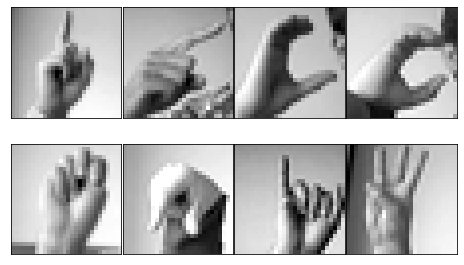

In [0]:
#Viewing samples of images
fig, axes = plt.subplots(2,4, figsize=(8,5),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.01, wspace=0.01))
for i, ax in enumerate(axes.flat):
  ax.imshow(x_train_img[i],cmap='gray')

#Principal Component Analysis (PCA)

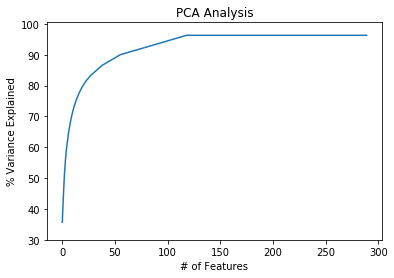

In [0]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
x_train_scaled = sc.fit_transform(x_train)
x_test_scaled = sc.transform(x_test)

pca = PCA(n_components=.99)
x_pca = pca.fit_transform(x_train_scaled)

variance = pca.explained_variance_ratio_ #calculate variance ratios
var=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=3)*100)
plt.ylabel('% Variance Explained')
plt.xlabel('# of Features')
plt.title('PCA Analysis')
plt.ylim(30,100.5)
plt.style.context('seaborn-whitegrid')
plt.plot(var)

In [0]:
#We can se that at ~60 components over 90% variance is captured and after is nearly constant
pca = PCA(n_components=60)
x_pca = pca.fit_transform(x_train_scaled)
x_test_pca = pca.transform(x_test_scaled)

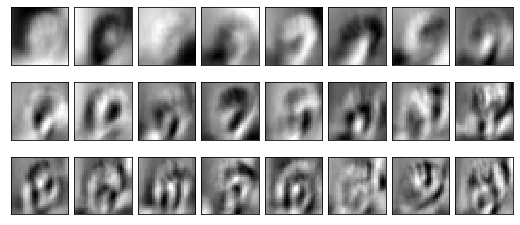

In [0]:
fig, axes = plt.subplots(3, 8, figsize=(9, 4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
    ax.imshow(pca.components_[i].reshape(28, 28), cmap='gray')

#Ensembles and classification models

We first use PCA components for four different classifiers(decision tree, kNN, Logistic regression and Random forest classifier) and then we use three different ensemble methods, bagging, boosting and stacking to compare the results.

##Bagging

In [0]:
import matplotlib.gridspec as gridspec
import itertools

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import cross_val_score, train_test_split

from mlxtend.plotting import plot_learning_curves
from mlxtend.plotting import plot_decision_regions

###Decision Trees

In [0]:
#Lets train sample decision tree with default values
dt0 = DecisionTreeClassifier()
dt0.fit(x_pca, train_label)

y_pred = dt0.predict(x_test_pca)

In [0]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(test_label,y_pred)
acc

0.5020914668153932

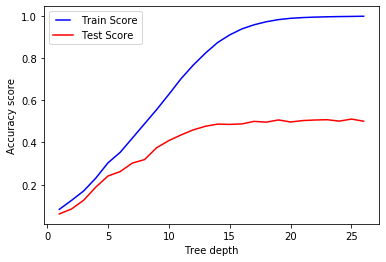

In [0]:
max_depths = np.linspace(1, 26, 26, endpoint=True)

train_results = []
test_results = []

for max_depth in max_depths:
   dt = DecisionTreeClassifier(max_depth=max_depth)
   dt.fit(x_pca, train_label)

   train_pred = dt.predict(x_pca)
   acc = accuracy_score(train_label,train_pred)
   train_results.append(acc)

   y_pred = dt.predict(x_test_pca)
   acc = accuracy_score(test_label,y_pred)
   test_results.append(acc)
  
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, 'b', label="Train Score")
line2, = plt.plot(max_depths, test_results, 'r', label="Test Score")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('Accuracy score')
plt.xlabel('Tree depth')
plt.show()

We can see that the dept of 20 is the best score for our decision tree so we set that to our max_depth

###k-Nearest-Neighbors

In [0]:
#Train knn with only 1-nearest-neighbor
knn0 = KNeighborsClassifier(n_neighbors=1)
knn0.fit(x_pca, train_label)

y_pred = knn0.predict(x_test_pca)

In [0]:
acc = accuracy_score(test_label,y_pred)
acc

0.8333798103736754

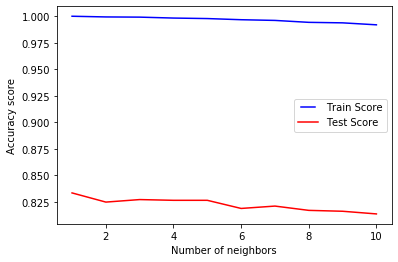

In [0]:
n_neighbors = np.linspace(1, 10, 10, endpoint=True,dtype=np.int64)

train_results = []
test_results = []

for k in n_neighbors:
   knn = KNeighborsClassifier(n_neighbors=k)
   knn.fit(x_pca, train_label)

   train_pred = knn.predict(x_pca)
   acc = accuracy_score(train_label,train_pred)
   train_results.append(acc)

   y_pred = knn.predict(x_test_pca)
   acc = accuracy_score(test_label,y_pred)
   test_results.append(acc)
  
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(n_neighbors, train_results, 'b', label="Train Score")
line2, = plt.plot(n_neighbors, test_results, 'r', label="Test Score")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('Accuracy score')
plt.xlabel('Number of neighbors')
plt.show()

We can see that setting 1 as 'k' we acieve the best score for our decision tree so we set that to our n_neighbors.

###Bagging all models

In [0]:
dt_f = DecisionTreeClassifier(max_depth=20)
knn_f = KNeighborsClassifier(n_neighbors=1)
lr_f = LogisticRegression()

bagging_dt = BaggingClassifier(base_estimator= dt_f , n_estimators=10, max_samples=0.7, max_features=0.9)
bagging_knn = BaggingClassifier(base_estimator= knn_f, n_estimators=10, max_samples=0.7, max_features=0.9)
bagging_lr = BaggingClassifier(base_estimator= lr_f, n_estimators=10, max_samples=0.7, max_features=0.9)

In [0]:
label = ['Decision Tree', 'K-NN', 'Logistic Regression', 'Bagging Tree', 'Bagging K-NN', 'Bagging Logistic Regression']
classifiers = [dt_f, knn_f, lr_f, bagging_dt, bagging_knn,bagging_lr]

for clf, label in zip(classifiers, label):        
    scores = cross_val_score(clf, x_pca, train_label, cv=3, scoring='accuracy')
    print("Accuracy: %.2f (+/- %.2f) [%s]" %(scores.mean(), scores.std(), label))

Accuracy: 0.94 (+/- 0.01) [Decision Tree]
Accuracy: 1.00 (+/- 0.00) [K-NN]
Accuracy: 0.84 (+/- 0.00) [Logistic Regression]
Accuracy: 0.99 (+/- 0.00) [Bagging Tree]
Accuracy: 0.99 (+/- 0.00) [Bagging K-NN]
Accuracy: 0.83 (+/- 0.01) [Bagging Logistic Regression]


###Random Forest Classification

Above we have seen all the cross validation scores for single classifiers and using bagging as an ensemble method

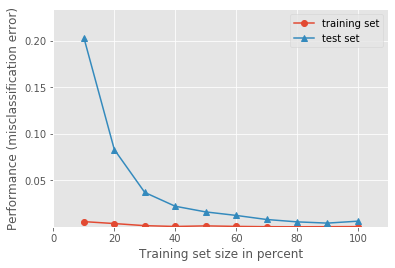

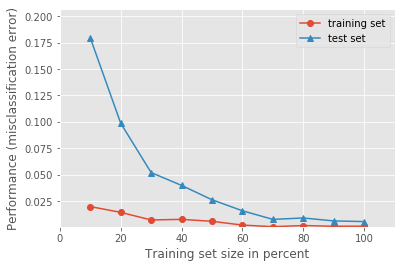

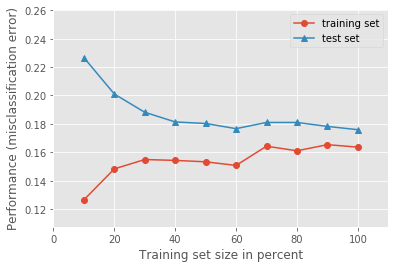

In [0]:
#Now lets see the effect of max_samples meaning the effect of subsampling the data
bags = [bagging_dt, bagging_knn, bagging_lr]
x_train0, x_test0, y_train0, y_test0 = train_test_split(x_pca, train_label, test_size=0.3, random_state=7)
for b in bags:
 plt.figure()
 plot_learning_curves(x_train0, y_train0, X_test0, y_test0, b, print_model=False, style='ggplot')
 plt.show()

Tables are for  'Bagging Tree', 'Bagging K-NN' and 'Bagging Logistic Regression' respectively. 
As we can see in all tables choosing ~80% data as training data we achieve the best ensemble models.

In [0]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'bootstrap': [True],
    'max_depth': [10,20,30,50],
    'max_features': [0.8, 0.9],
    'n_estimators': [10,20,50,100]
}
rf = RandomForestClassifier()
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)

In [0]:
grid_search.fit(x_pca, train_label)
grid_search.best_params_

Fitting 3 folds for each of 32 candidates, totalling 96 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 17.5min
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed: 52.9min finished


{'bootstrap': True, 'max_depth': 50, 'max_features': 0.8, 'n_estimators': 50}

In [0]:
best_grid = grid_search.best_estimator_
accuracy = best_grid.score(x_test_pca, test_label)
print("Accuracy score for Random Forest Classification is: %.2f" %accuracy)

Accuracy score for Random Forest Classification is: 0.76


##Boosting

In [0]:
import matplotlib.gridspec as gridspec
import itertools

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score, train_test_split

from mlxtend.plotting import plot_learning_curves
from mlxtend.plotting import plot_decision_regions

In [0]:
dt_f = DecisionTreeClassifier(max_depth=20)
boosting_dt = AdaBoostClassifier(base_estimator= dt_f , n_estimators=10)

In [0]:
label = ['Decision Tree','Boosting Tree']
classifiers = [dt_f, boosting_dt]

for clf, label in zip(classifiers, label):        
    scores = cross_val_score(clf, x_pca, train_label, scoring='accuracy')
    print("Accuracy: %.2f (+/- %.2f) [%s]" %(scores.mean(), scores.std(), label))

Accuracy: 0.94 (+/- 0.00) [Decision Tree]
Accuracy: 1.00 (+/- 0.00) [Boosting Tree]


Now we will plot the error based on the number of subsamples from the decision tree and plot the results

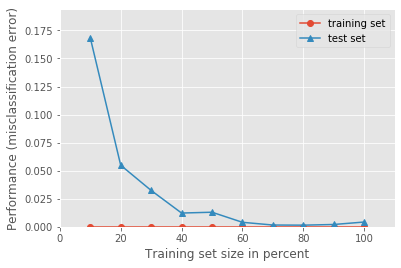

In [0]:
x_train0, x_test0, y_train0, y_test0 = train_test_split(x_pca, train_label, test_size=0.3, random_state=7)

plt.figure()
plot_learning_curves(x_train0, y_train0, x_test0, y_test0, boosting_dt, print_model=False, style='ggplot')
plt.show()

We will now see the effect of number of estimators on our final result, we use the standard deviation as the identifier of the error for each number estimators.

In [0]:
num_est = map(int, np.linspace(1,100,20))
boosting_mean = []
boosting_std = []
for n_est in num_est:
    boosting = AdaBoostClassifier(base_estimator=clf, n_estimators=n_est)
    scores = cross_val_score(boosting, x_pca, train_label, cv=3, scoring='accuracy')
    boosting_mean.append(scores.mean())
    boosting_std.append(scores.std())

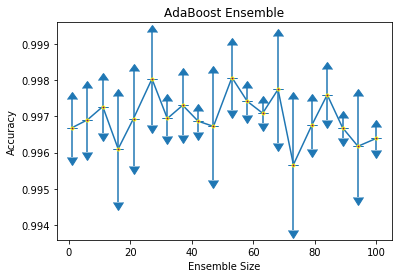

In [0]:
num_est = np.linspace(1,100,20).astype(int)
plt.figure()
plt.errorbar(num_est, boosting_mean, yerr=boosting_std, uplims=True, lolims=True, fmt='-o', capsize=5,
             marker='.',mfc='purple', mec='yellow',
             label='uplims=True, lolims=True')
plt.ylabel('Accuracy'); plt.xlabel('Ensemble Size'); plt.title('AdaBoost Ensemble');
plt.show()

##Stacking

In [0]:
import matplotlib.gridspec as gridspec
import itertools

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import StackingClassifier

from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score, train_test_split

from mlxtend.plotting import plot_learning_curves
from mlxtend.plotting import plot_decision_regions

Now lets stack the models and using logistic regression as our meta classifier to see the results

In [0]:
knn = KNeighborsClassifier(n_neighbors=1)
rf = RandomForestClassifier(random_state=1)
gbc = GaussianNB()
lr = LogisticRegression()
sclf = StackingClassifier(classifiers=[knn, rf, gbc], 
                          meta_classifier=lr)

In [0]:
label = ['KNN', 'Random Forest', 'Naive Bayes', 'Stacking Classifier']
clf_list = [knn, rf, gbc, sclf]

stacking_mean = []
stacking_std = []
for clf, label in zip(clf_list, label):    
    scores = cross_val_score(clf, x_pca, train_label, cv=3, scoring='accuracy')
    print ("Accuracy: %.2f (+/- %.2f) [%s]" %(scores.mean(), scores.std(), label))
    stacking_mean.append(scores.mean())
    stacking_std.append(scores.std())

Accuracy: 1.00 (+/- 0.00) [KNN]
Accuracy: 1.00 (+/- 0.00) [Random Forest]
Accuracy: 0.75 (+/- 0.00) [Naive Bayes]
Accuracy: 0.40 (+/- 0.01) [Stacking Classifier]


Now lets plot the accuracy of each model and the possible error in each

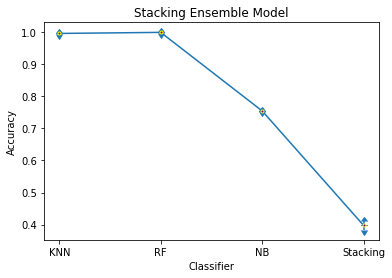

In [0]:
plt.figure()
plt.errorbar(range(4), stacking_mean, yerr=stacking_std, uplims=True, lolims=True, fmt='-o', capsize=3,
             marker='.',mfc='purple', mec='yellow',
             label='uplims=True, lolims=True')
plt.xticks(range(4), ['KNN', 'RF', 'NB', 'Stacking'])        
plt.ylabel('Accuracy'); plt.xlabel('Classifier'); plt.title('Stacking Ensemble Model');
plt.show()

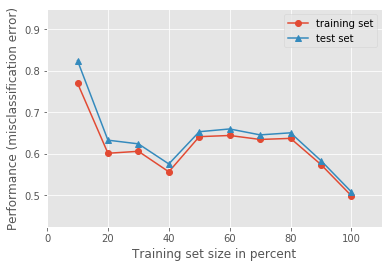

In [0]:
x_train0, x_test0, y_train0, y_test0 = train_test_split(x_pca, train_label, test_size=0.3, random_state=7)

plt.figure()
plot_learning_curves(x_train0, y_train0, x_test0, y_test0, sclf, print_model=False, style='ggplot')
plt.show()

We can seee that as number of training samples goes highere due to high variance of data the accuracy of model drasrically drops, however we can see that in Stacking we do not see any over fitting.

###Final Predictions

In [0]:
knn = KNeighborsClassifier(n_neighbors=1)
dt = DecisionTreeClassifier(max_depth=20)
gbc = GaussianNB()
lr = LogisticRegression()
bagging_dt = BaggingClassifier(base_estimator= dt , n_estimators=10, max_samples=0.8, max_features=0.9)
bagging_knn = BaggingClassifier(base_estimator= knn, n_estimators=10, max_samples=0.8, max_features=0.9)
bagging_lr = BaggingClassifier(base_estimator= lr, n_estimators=10, max_samples=0.8, max_features=0.9)
boosting_dt = AdaBoostClassifier(base_estimator= dt_f , n_estimators=10)
sclf = StackingClassifier(classifiers=[knn, rf, gbc], meta_classifier=lr)

In [0]:
from sklearn.metrics import accuracy_score

classifiers_unsupervised = [knn, dt, bagging_dt,bagging_knn, bagging_lr,  boosting_dt, sclf]
classifiers_names1 = ['K-NN', 'Decision Tree', 'Bagging Tree',
                     'Bagging K-NN', 'Bagging Logistic Regression', 'Boosting tree', 'Stacking Model']
for clf, n in zip(classifiers_unsupervised, classifiers_names1):
  clf.fit(x_pca, train_label)
  pred = clf.predict(x_test_pca)
  accuracy = accuracy_score(pred, test_label)
  print("Accuracy score for %s is: %.2f" %(n, accuracy))

Accuracy score for K-NN is: 0.83
Accuracy score for Decision Tree is: 0.52
Accuracy score for Bagging Tree is: 0.67
Accuracy score for Bagging K-NN is: 0.84
Accuracy score for Bagging Logistic Regression is: 0.66
Accuracy score for Boosting tree is: 0.61
Accuracy score for Stacking Model is: 0.28


In [0]:
classifiers_supervised  = [gbc, lr]
classifiers_names2 = ['Naive Bayes', 'Logistic Regression']

for clf2, n in zip(classifiers_supervised, classifiers_names2):
  clf2.fit(x_pca, train_label)
  pred = clf2.predict(x_test_pca)
  accuracy = accuracy_score(pred, test_label)
  print("Accuracy score for %s is: %.2f" %(n, accuracy))

Accuracy score for Naive Bayes is: 0.64
Accuracy score for Logistic Regression is: 0.67


#Support Vector Machines

##Support Vector Machines (SVM) + PCA

In [0]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100]},
                    {'kernel': ['linear'], 'C': [1, 10, 100]}]
svm = GridSearchCV(SVC(probability=True), tuned_parameters, refit=True, verbose=1)
svm.fit(x_pca, train_label)
print(svm.best_params_)
print(svm.best_estimator_)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed: 26.6min finished


{'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)


In [0]:
from sklearn.svm import SVC

svm = SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)


In [0]:
#Training SVM
svm.fit(x_pca,train_label)
pred=svm.predict(x_test_pca)
accuracy = accuracy_score(pred, test_label)
print("Accuracy score for Support Vector Machine is: %.2f" %accuracy)

Accuracy score for Support Vector Machine is: 0.83


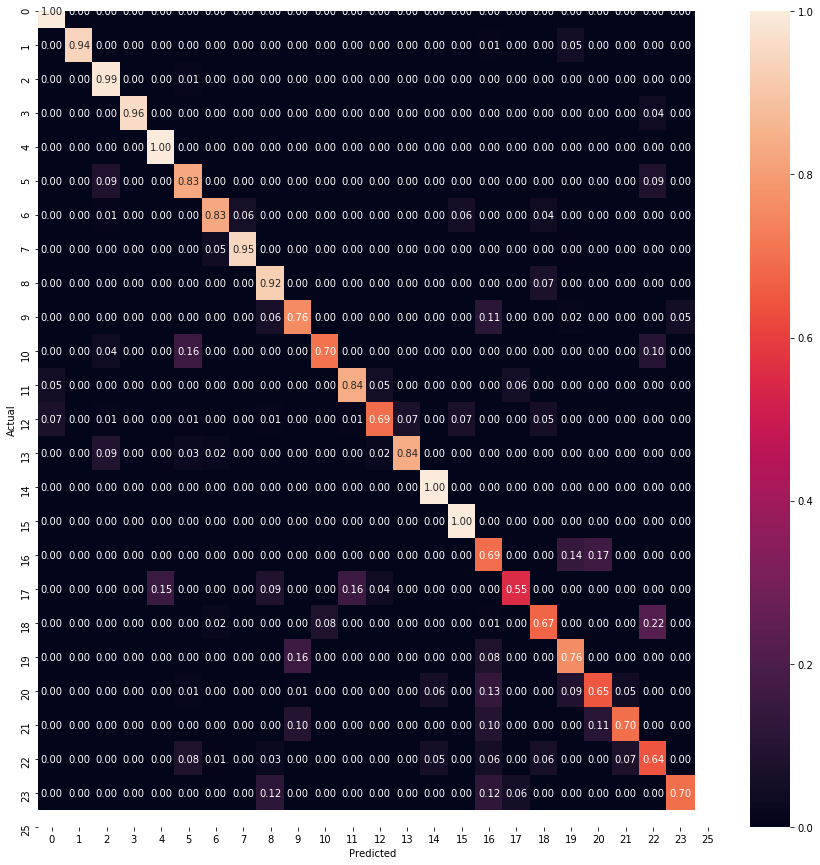

In [0]:
#Graph confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
labels = np.linspace(0, 25, 25, endpoint=True,dtype=np.int64)
cm = confusion_matrix(test_label, pred)
# Normalize
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

##Exctracting Hog Features

In [0]:
from skimage.feature import hog
from skimage import data, color, exposure
hogtrain = []
hogimg = []
for i in range(x_train_img.shape[0]):
  fd, hog_image = hog(x_train_img[i], orientations=8, pixels_per_cell=(8,8),cells_per_block=(2,2), visualise=True)
  hogtrain.append(fd)
  hogimg.append(hog_image)

hog_feature = np.array(hogtrain)

In [0]:
hogtest = []
hogimg_test = []
for i in range(x_test_img.shape[0]):
  fd, hog_image = hog(x_test_img[i], orientations=8, pixels_per_cell=(8,8),cells_per_block=(2,2), visualise=True)
  hogtest.append(fd)
  hogimg_test.append(hog_image)

hog_feature_test = np.array(hogtest)

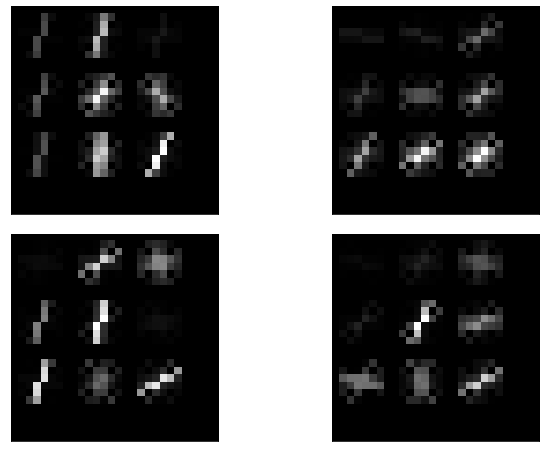

In [0]:
fig, axes = plt.subplots(2, 2, figsize=(11, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
    ax.imshow(hogimg[i], cmap='gray')

##Support Vector Machines (SVM) + HOG

In [0]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100]}]
svm2 = GridSearchCV(SVC(probability=True), tuned_parameters, refit=True, verbose=1)
svm2.fit(hog_feature, train_label)
print(svm2.best_params_)
print(svm2.best_estimator_)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed: 140.5min finished


{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)


In [0]:
from sklearn.metrics import accuracy_score

svm2.fit(hog_feature,train_label)
pred = svm2.predict(hog_feature_test)
accuracy = accuracy_score(pred, test_label)
print("Accuracy score for Support Vector Machine using HOG features is: %.2f" %accuracy)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed: 142.2min finished


Accuracy score for Support Vector Machine using HOG features is: 0.89


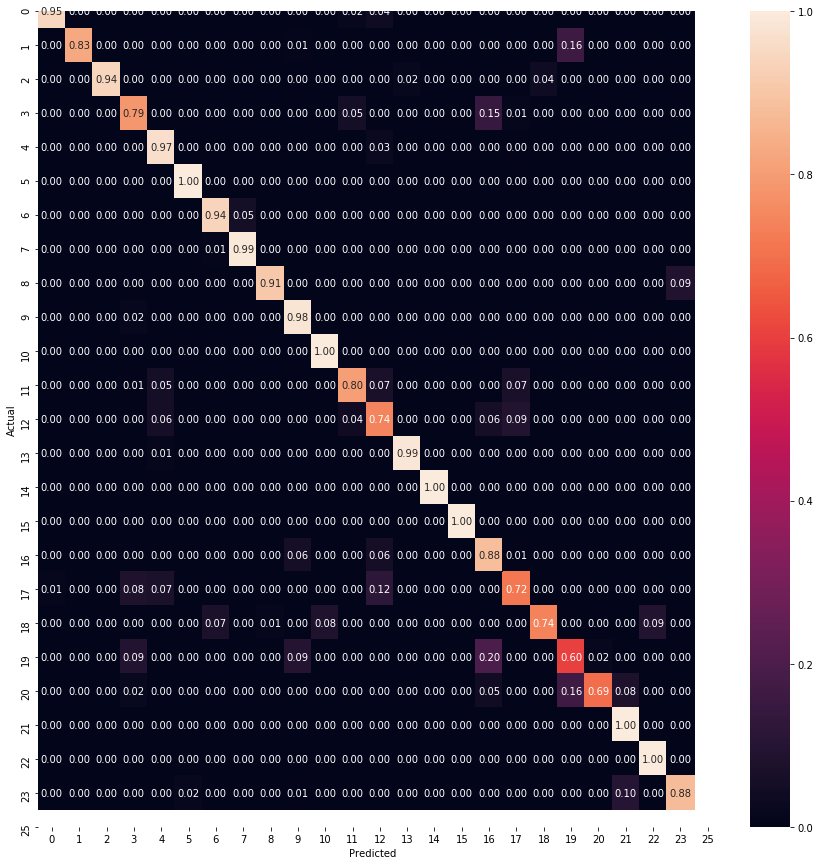

In [0]:
#Graph confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

labels = np.linspace(0, 25, 25, endpoint=True,dtype=np.int64)
cm = confusion_matrix(test_label, pred)
# Normalize
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

##Support Vector Machines (SVM) + HOG + PCA

In [0]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pca_hogs = PCA(n_components=.99)
x_hogs_pca = pca_hogs.fit_transform(hog_feature)
x_hogs_pca_test = pca_hogs.transform(hog_feature_test)

In [0]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

svm2 = SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)
svm2.fit(x_hogs_pca,train_label)
pred = svm2.predict(x_hogs_pca_test)
accuracy = accuracy_score(pred, test_label)
print("Accuracy score for Support Vector Machine by applying PCA on HOG features is: %.2f" %accuracy)

Accuracy score for Support Vector Machine by applying PCA on HOG features is: 0.89


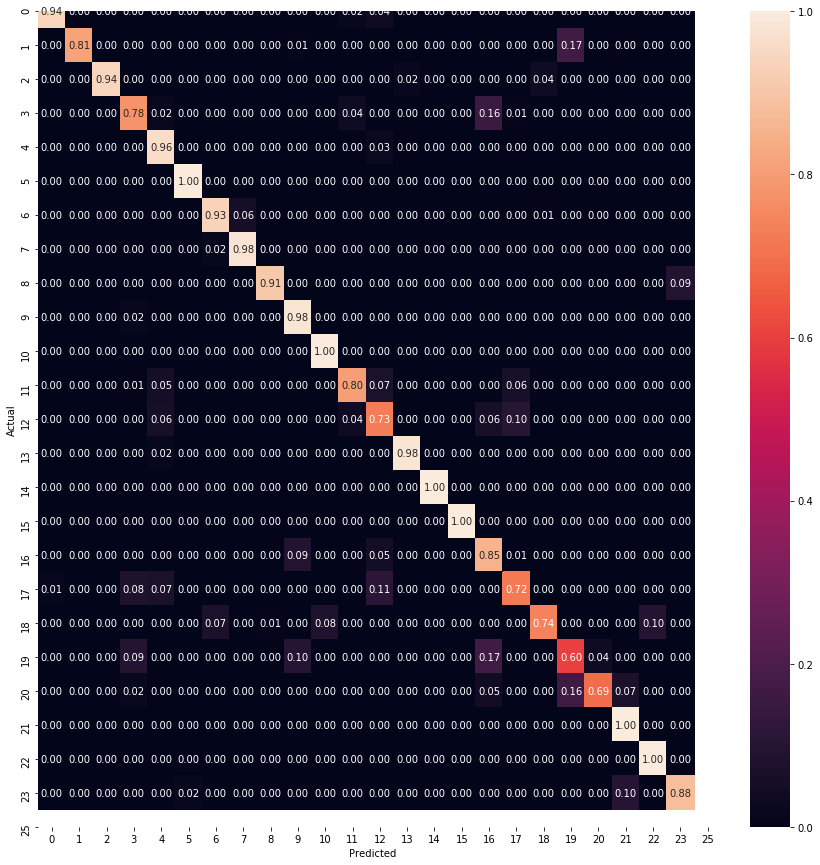

In [0]:
#Graph confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

labels = np.linspace(0, 25, 25, endpoint=True,dtype=np.int64)
cm = confusion_matrix(test_label, pred)
# Normalize
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

#k-Nearest-Neighbors + HOG

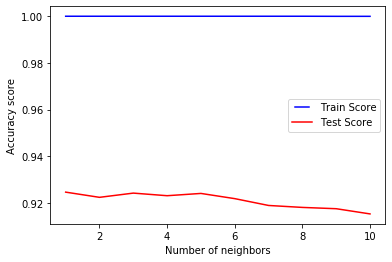

In [0]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

n_neighbors = np.linspace(1, 10, 10, endpoint=True,dtype=np.int64)

train_results = []
test_results = []

for k in n_neighbors:
   knn = KNeighborsClassifier(n_neighbors=k)
   knn.fit(hog_feature, train_label)

   train_pred = knn.predict(hog_feature)
   acc = accuracy_score(train_label,train_pred)
   train_results.append(acc)

   y_pred = knn.predict(hog_feature_test)
   acc = accuracy_score(test_label,y_pred)
   test_results.append(acc)
  
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(n_neighbors, train_results, 'b', label="Train Score")
line2, = plt.plot(n_neighbors, test_results, 'r', label="Test Score")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('Accuracy score')
plt.xlabel('Number of neighbors')
plt.show()

We can observe that 3 neighbors performs the best therefore in our final model we will set 'K' to three.

In [0]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(hog_feature, train_label)

pred = knn.predict(hog_feature_test)
acc = accuracy_score(test_label, pred)

print("Accuracy score for Support Vector Machine by using HOG features is: %.2f" %acc)

Accuracy score for Support Vector Machine by using HOG features is: 0.92


#Stacking Support Vectors Machine and kNN using HOG features

In [0]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from mlxtend.classifier import StackingClassifier

from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

In [0]:

knn = KNeighborsClassifier(n_neighbors=3)
svm2 = SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)
lr = LogisticRegression()

sclf = StackingClassifier(classifiers=[knn,svm2], 
                          meta_classifier=lr)

In [0]:
scores = cross_val_score(sclf, hog_feature, train_label, cv=3, scoring='accuracy')
print ("Accuracy: %.2f (+/- %.2f) [Stacking Classifier]" %(scores.mean(), scores.std()))

Accuracy: 0.49 (+/- 0.02) [Stacking Classifier]


In [0]:
sclf.fit(hog_feature, train_label)
pred = sclf.predict(hog_feature_test)
accuracy = accuracy_score(pred, test_label)
print("Accuracy score for Stacking Classifier is: %.2f" %accuracy)

Accuracy score for Stacking Classifier is: 0.40


#Convolutional Neural Network (CNN)

In [0]:
#For CNN we need RGB images lets transform our images in 3D dimension
from skimage.color import gray2rgb

x_train_cnn = gray2rgb(x_train_img)
x_test_cnn = gray2rgb(x_test_img)

In [0]:
#Normalizing the pixels
x_train_cnn = x_train_cnn / 255
x_test_cnn = x_test_cnn / 255

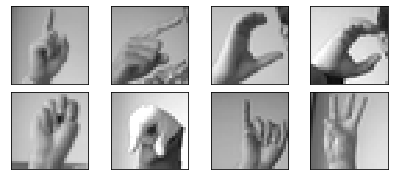

In [0]:
#Lets view some samples
fig, axes = plt.subplots(2, 4, figsize=(7, 3),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
    ax.imshow(x_train_cnn[i])

In [0]:
#For CNN we need One-hot labels which are stored in y_train nd y_test
y_train[0]

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
import warnings
warnings.filterwarnings("ignore")

model = Sequential()

In [0]:
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28,28,3)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(2000, activation='relu'))
model.add(Dense(26, activation='softmax')) 

In [0]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [0]:
#Lets check available gpu
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [0]:
hist = model.fit(x_train_cnn, y_train,
           batch_size=128, epochs=25, validation_split=0.3 )

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 19218 samples, validate on 8237 samples
Epoch 1/25





19218/19218 [==============================] - 12s 622us/step - loss: 1.1718 - acc: 0.6373 - val_loss: 0.1438 - val_acc: 0.9649
Epoch 2/25
19218/19218 [==============================] - 2s 90us/step - loss: 0.1616 - acc: 0.9462 - val_loss: 0.0106 - val_acc: 0.9993
Epoch 3/25
19218/19218 [==============================] - 2s 90us/step - loss: 0.0593 - acc: 0.9814 - val_loss: 0.0091 - val_acc: 0.9985
Epoch 4/25
19218/19218 [==============================] - 2s 90us/step - loss: 0.0376 - acc: 0.9873 - val_loss: 0.0012 - val_acc: 1.0000
Epoch 5/25
19218/19218 [==============================] - 2s 91us/step - loss: 0.0296 - acc: 0.9906 - val_loss: 0.0010 - val_acc: 1.0000
Epoch 6/25
19218/19218 [==============================] - 2s 91us/step - loss: 0.0203 - acc: 0.9941 - val_loss: 8.3715e-04 - val_acc: 0.9999
Epoch 7/25
19218/1921

We achieved an accuracy of 99.8% over the training data

In [0]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 26, 26, 32)        896       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 10, 10, 64)        18496     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 8, 8, 64)          36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1024)             

In [0]:
model.evaluate(x_test_cnn, y_test)[1]

7172/7172 [==============================] - 1s 89us/step


0.9636084774121584

The model is around 96% on test data



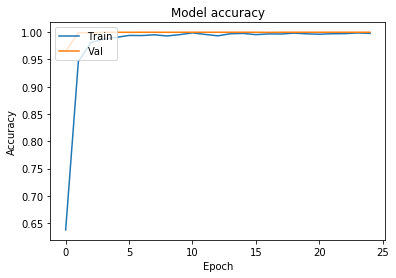

In [0]:
#Visualize the models accuracy
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

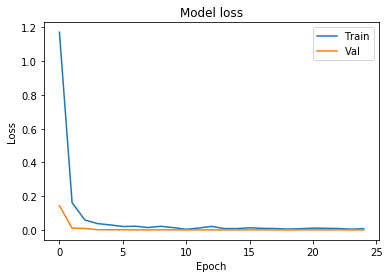

In [0]:
#Visualize the models loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

#Saving the trained model


In [0]:
#Save the model
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# 2. Save Keras Model or weights on google drive

# create on Colab directory
model.save('model.h5')    
model_file = drive.CreateFile({'title' : 'model.h5'})
model_file.SetContentFile('model.h5')
model_file.Upload()

# download to google drive
drive.CreateFile({'id': model_file.get('id')})

GoogleDriveFile({'id': '1N6JlAflv2fIrXFVZ14DPK0CEPicpQyVd'})

In [0]:
#Save the model weights
model.save_weights('model_weights.h5')
weights_file = drive.CreateFile({'title' : 'model_weights.h5'})
weights_file.SetContentFile('model_weights.h5')
weights_file.Upload()
drive.CreateFile({'id': weights_file.get('id')})

GoogleDriveFile({'id': '1V80594ylh7Rs5sRBvg9bfhnbkM6m9hg8'})

In [0]:
# 3. reload weights from google drive into the model

# use (get shareable link) to get file id
last_weight_file = drive.CreateFile({'id': '1N6JlAflv2fIrXFVZ14DPK0CEPicpQyVd'}) 
last_weight_file.GetContentFile('last_weights.mat')
model.load_weights('last_weights.mat')

#Capturing live images and predicting the output

The code below is used for using the local webcam as this device is using a virtual machine to run the webcam set to the Jupyter notebook is not the local webcam. The code is retrieved from Google Colab team from:  https://colab.research.google.com/notebooks/snippets/advanced_outputs.ipynb#scrollTo=2viqYx97hPMi

In [0]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [0]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format('image1.jpg'))
  
  # Show the image which was just taken.
  display(Image('photo.jpg'))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [0]:
import cv2 as cv

img = cv.imread('/content/photo.jpg', cv.IMREAD_UNCHANGED)
# to crop required part
im2 = img
# convert to grayscale    
image_grayscale = cv.cvtColor(im2, cv.COLOR_BGR2GRAY)
# blurring the image 
image_grayscale_blurred =cv.GaussianBlur(image_grayscale, (15,15), 0)
# resize the image to 28x28
im3 = cv.resize(image_grayscale_blurred, (28,28), interpolation = cv.INTER_AREA)
# expand the dimensions from 28x28 to 1x28x28x1
im4 = np.resize(im3, (28, 28, 3))
im5 = np.expand_dims(im4, axis=0)

In [0]:
data = np.asarray( im4, dtype="int32" )
pred_probab = model.predict(data)[0]
# softmax gives probability for all the alphabets hence we have to choose the maximum probability alphabet 
pred_class = list(pred_probab).index(max(pred_probab))
max(pred_probab), getLetter(pred_class)

The Three cells above are just for testing therefore the outputs have been removed, for demo you can run the blocks in order in order to see the final result predicted by the neural network.

In [0]:
'''This method will simply change the 
final result to letters since the nueral net will predict indexes of teh alphabet
'''
def getLetter(i):
  alphabet='ABCDEFGHIJKLMNOPQRSTUVWXYZ'
  return alphabet[i]